##### 다항 분류

In [1]:
# 앞의 와인 데이터세트에서 wine의 quality는 0에서 10까지 숫자로 구분되어 있기 때문에 이 데이트를 다항 분류의 범주로 
# 사용할 수 있다. 이 파일에서는 와인의 색깔대신 품질을 예측해보자.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
import pandas as pd
red = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
white = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

red['type'] = 0
white['type'] = 1

wine = pd.concat([red, white], axis=0)  # row-wise concatenation
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


In [3]:
print(wine['quality'].describe().round(3))

count    6497.000
mean        5.818
std         0.873
min         3.000
25%         5.000
50%         6.000
75%         6.000
max         9.000
Name: quality, dtype: float64


In [4]:
print(wine['quality'].value_counts())

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


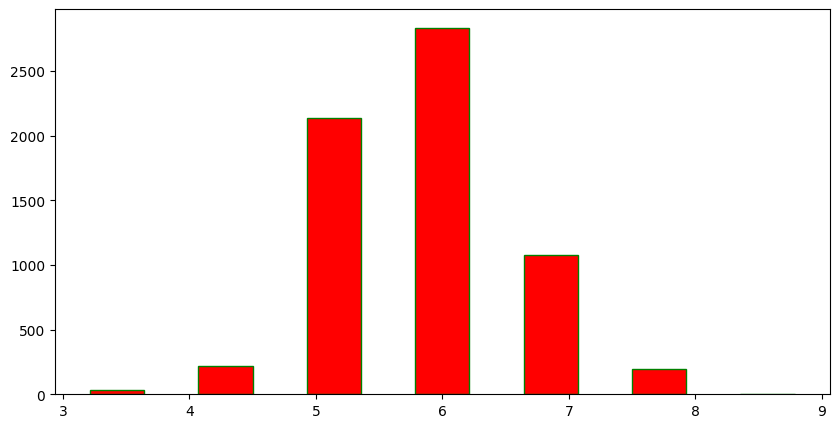

In [5]:
plt.figure(figsize=(10,5))
plt.hist(wine['quality'], bins=7, rwidth=0.5, color='red', edgecolor='green')
plt.show()

In [6]:
# 데이터의 양이 적고 범주의 수가 너무 많은 데다 히스토그램에서 볼 수 있듯이 각 데이터의 숫자가 차이나기 때문에 모든 
# 범주에 대한 세세한 분류는 어려울 것 같다. 그래서 범주를 크게 세 가지로 재분류해보자.
# 품질 3~5는 나쁨, 6은 보통, 7이상은 좋음으로 분류한다.
# 이렇게 품질 데이터를 재분류한 뒤에는 각 카테고리의 항목 수가 어는 정도 비슷해진 것을 볼 수 있다.

wine.loc[wine['quality']<=5, 'new_quality'] = 0
wine.loc[wine['quality']==6, 'new_quality'] = 1
wine.loc[wine['quality']>=7, 'new_quality'] = 2

wine['new_quality'].value_counts()

1.0    2836
0.0    2384
2.0    1277
Name: new_quality, dtype: int64

In [7]:
wine[['quality', 'new_quality']].describe().round(3)

,quality,new_quality
count,6497.000,6497.000
mean,5.818,0.830
std,0.873,0.731
min,3.000,0.000
25%,5.000,0.000
50%,6.000,1.000
75%,6.000,1.000
max,9.000,2.000


In [8]:
# new_quality라는 새로운 목표변수가 만들어졌으므로 quality속성을 제거하자.
del wine['quality']

In [9]:
# 이제 데이터 정규화와 훈련데이터와 테스트데이터로 분리하자.
wine_norm = (wine - wine.min()) / (wine.max() - wine.min())
wine_shuffle = wine_norm.sample(frac=1)
wine_np = wine_shuffle.to_numpy()

train_idx = int(len(wine_np) * 0.8)
train_X, train_Y = wine_np[:train_idx, :-1], wine_np[:train_idx, -1]
test_X, test_Y = wine_np[train_idx:, :-1], wine_np[train_idx:, -1]

train_Y = tf.keras.utils.to_categorical(train_Y, num_classes=3)
test_Y = tf.keras.utils.to_categorical(test_Y, num_classes=3)

In [10]:
# 자, 학습을 진행합시다!
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=48, activation='relu', input_shape=(12,)),
    tf.keras.layers.Dense(units=24, activation='relu'),
    tf.keras.layers.Dense(units=12, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.07), loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                624       
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 3)                 39        
                                                                 
Total params: 2,139
Trainable params: 2,139
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(train_X, train_Y, epochs=25, batch_size=32, validation_split=0.25)

Epoch 1/25
122/122 [==============================] - 2s 5ms/step - loss: 0.4866 - accuracy: 0.7988 - val_loss: 0.4131 - val_accuracy: 0.8123
Epoch 2/25
122/122 [==============================] - 0s 4ms/step - loss: 0.4159 - accuracy: 0.8006 - val_loss: 0.3926 - val_accuracy: 0.8123
Epoch 3/25
122/122 [==============================] - 0s 4ms/step - loss: 0.4233 - accuracy: 0.8004 - val_loss: 0.3978 - val_accuracy: 0.8123
Epoch 4/25
122/122 [==============================] - 0s 4ms/step - loss: 0.4131 - accuracy: 0.8114 - val_loss: 0.4141 - val_accuracy: 0.8123
Epoch 5/25
122/122 [==============================] - 0s 4ms/step - loss: 0.4172 - accuracy: 0.8057 - val_loss: 0.4065 - val_accuracy: 0.7908
Epoch 6/25
122/122 [==============================] - 0s 4ms/step - loss: 0.4135 - accuracy: 0.7998 - val_loss: 0.4672 - val_accuracy: 0.8123
Epoch 7/25
122/122 [==============================] - 0s 4ms/step - loss: 0.4171 - accuracy: 0.7998 - val_loss: 0.4119 - val_accuracy: 0.8123
Epoch 

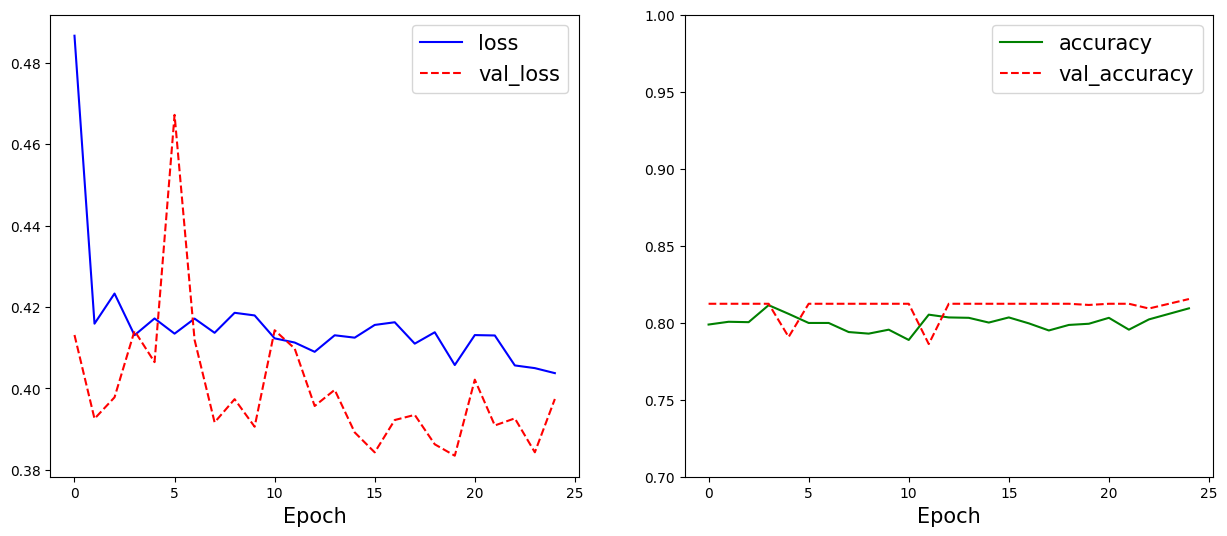

In [12]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch', size=15)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch', size=15)
plt.legend(fontsize=15)
plt.ylim(0.7, 1)

plt.show()

In [13]:
# 학습결과 시각화 결과를 보면 이항 분류보다 정답을 찾기 어려운 문제이기 때문인지 val_loss가 중간에 튀기도 하고 전반적
# 으로 loss보다 큰 값인 것을 확인할 수 있다. 학습을 계속하면 loss는 꾸준히 낮아지겠지만 네트워크가 훈련데이터에 
# overfitting되기 때문에 val_loss는 꾸준히 증가할 것으로 예상된다.
# 테스트데이터로 정확도를 평가해보자.

model.evaluate(x=test_X, y=test_Y)

41/41 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.7969


[0.4299951493740082, 0.7969231009483337]

In [14]:
# 테스트데이터로 평가해본 결과 정확도는 80.31%로서 훈련데이터 정확도(79.80%), 검증데이터 정확도(79.31%)보다 조금
# 더 높게 나온다. 데이터의 구성이 균일하지 않기 때문에 이 이상으로 좋은 성과를 내기 위해서는 네트워크의 크기를 
# 키워보거나 학습률을 조정해보는 등 다양한 방면으로 노력해봐야 한다.